---
# Analysis of Hotel Reviews: Transforming Customer Feedback to Actionable Business Insights
---

## 1. Project Objective

This project aims to develop and implement a robust data analysis workflow to transform a large volume of unstructured hotel reviews into a structured, actionable business intelligence dashboard. The primary goal is to provide hotel management with precise, data-driven recommendations to enhance guest satisfaction and operational efficiency.

## 2. Methodology

To achieve this, the project utilizes a Hybrid Analysis System that combines:
* **Rule-Based Linguistic Analysis:** For high-precision tasks like sarcasm detection and topic extraction.
* **State-of-the-Art Language Models (LLMs):** For nuanced contextual understanding in sentiment analysis and abstractive summarization.
* **Quality Assurance Logic:** A built-in validation and fallback mechanism ensures the reliability and quality of every generated insight.

## 3. Key Technologies
* **Programming Language:** Python
* **NLP & Machine Learning:** Hugging Face Transformers, PyTorch
* **Models:** `nlptown/bert-base-multilingual-uncased-sentiment`, `facebook/bart-large-cnn`, `google/pegasus-xsum`(as a backup)

## 4. Dataset
The analysis is performed on the **Trip Advisor Hotel Reviews** dataset, sourced from Kaggle.
* **Link:** [https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)



#1. INSTALLASION

In [46]:
!pip install transformers accelerate wordcloud -q

In [47]:
!pip install adjustText

In [48]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import re
import warnings
from typing import List, Dict
from tqdm.auto import tqdm
import gc
warnings.filterwarnings('ignore')
from adjustText import adjust_text
from itertools import product
import random


#2. DATA FOUNDATION

In [50]:
# URL of the dataset on GitHub
url = "https://raw.githubusercontent.com/amdihsann/Dataset-/refs/heads/main/Classification_hotel_review/tripadvisor_hotel_reviews.csv"

# Reading a CSV file into a Pandas DataFrame
df = pd.read_csv(url)

##1) Data Cleaning

In [51]:
# Check and delete duplicates
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"- deleting {initial_rows - len(df)} duplicates row.")


- deleting 0 duplicates row.


In [52]:
# Check and delete missing values ​​in the 'Review' column.
initial_rows = len(df)
df.dropna(subset=['Review'], inplace=True)
print(f"- deleting {initial_rows - len(df)} rows with empty review.")


- deleting 0 rows with empty review.


In [53]:
# Reset index after deleting rows
df.reset_index(drop=True, inplace=True)
print(f"- Data size after cleaning: {df.shape}")

- Data size after cleaning: (20491, 2)


In [54]:
print("\nThe first five rows of data:")
display(df.head())


The first five rows of data:


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [55]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


##2) Exploratory Data Analysis (EDA)

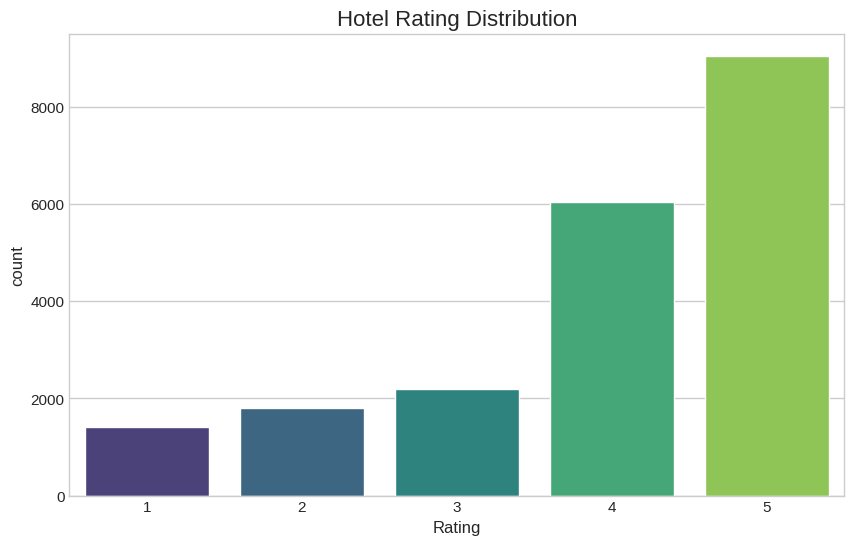

In [56]:
# Visualization of rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Rating', palette='viridis')
plt.title('Hotel Rating Distribution', fontsize=16)
plt.show()

This indicates a high level of overall guest satisfaction in the dataset. However, it also highlights a significant data imbalance, where negative and neutral reviews are substantially underrepresented. This imbalance is a critical factor to consider in the subsequent sentiment analysis to prevent any potential bias in the model's performance.

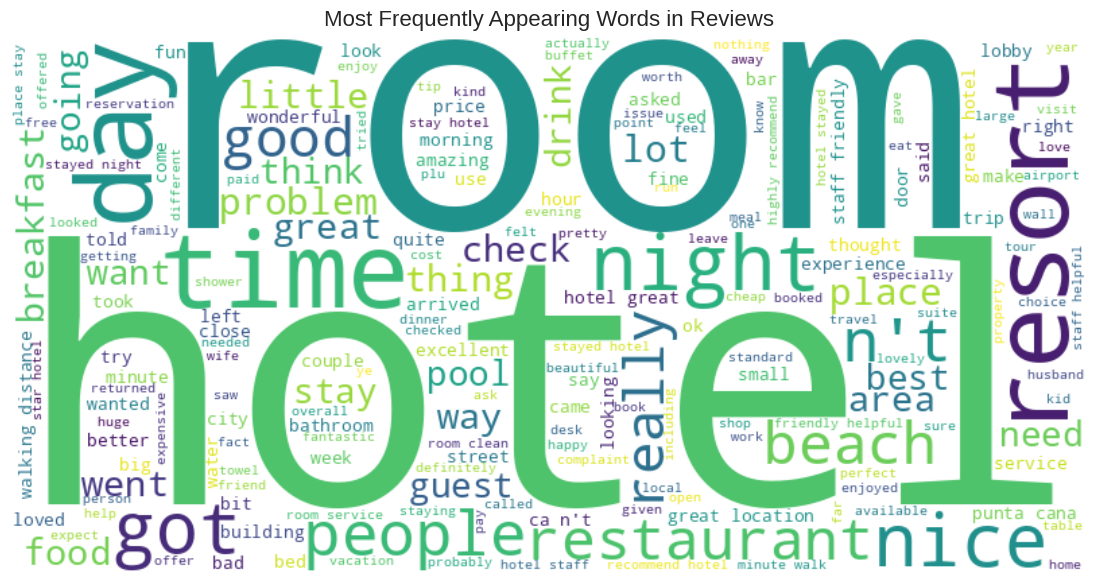

In [57]:
# Create a Word Cloud to see the most frequently occurring words.
all_reviews_text = ' '.join(df['Review'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequently Appearing Words in Reviews', fontsize=16)
plt.show()

The word cloud visually confirms the central themes of the guest experience. The prominence of words like "hotel," "room," "staff," "breakfast," and "location" reinforces that these core operational aspects are the most frequently discussed topics.

In [58]:
SAMPLE_SIZE = 200
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).copy()
print(f"\nWork with {SAMPLE_SIZE} rows sample for analysis AI  🔥")


Work with 200 rows sample for analysis AI  🔥


To ensure efficiency during the development and validation phase of the analysis pipeline, this project utilizes a representative random sample of 200 reviews.

#3. The Hybrid Analysis Engine

##1) System Development



In [59]:
class ProfessionalReviewAnalysisSystem:
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        if self.verbose:
            print(f"🚀 Initializing System on device: {self.device}")
        self.model_configs = self._get_model_configurations()
        self.models = self._initialize_models()
        self._setup_linguistic_patterns()
        if self.verbose:
            print("✅ System initialization complete.")

    def _get_model_configurations(self) -> Dict:
        return {
            'summarization_models': [
                {'name': 'facebook/bart-large-cnn', 'priority': 1, 'max_length': 1024, 'optimal_summary_length': (40, 150)},
                {'name': 'google/pegasus-xsum', 'priority': 2, 'max_length': 512, 'optimal_summary_length': (30, 120)},
            ],
            'sentiment_models': [
                {'name': 'nlptown/bert-base-multilingual-uncased-sentiment', 'priority': 1, 'labels': {0:'very negative',1:'negative',2:'neutral',3:'positive',4:'very positive'}}
            ]
        }

    def _initialize_models(self) -> Dict:
        models = {'summarization': None, 'sentiment': None}

        # Load Summarization Model
        if self.verbose: print("\n📚 Loading Summarization Model...")
        for config in self.model_configs['summarization_models']:
            try:
                if self.verbose: print(f"  🔄 Trying {config['name']}...")
                tokenizer = AutoTokenizer.from_pretrained(config['name'])
                model = AutoModelForSeq2SeqLM.from_pretrained(config['name'],
                    torch_dtype=torch.float16 if self.device == 'cuda' else torch.float32).to(self.device)
                models['summarization'] = {'tokenizer': tokenizer, 'model': model, 'config': config}
                if self.verbose: print(f"  ✅ Successfully loaded {config['name']}")
                break
            except Exception as e:
                if self.verbose: print(f"  ❌ Failed to load {config['name']}: {str(e)[:100]}")
                gc.collect(); torch.cuda.empty_cache()

        # Load Sentiment Model
        if self.verbose: print("\nLoading Sentiment Model...")
        for config in self.model_configs['sentiment_models']:
            try:
                if self.verbose: print(f"  🔄 Trying {config['name']}...")
                pipeline_instance = pipeline("sentiment-analysis", model=config['name'],
                    device=0 if self.device == "cuda" else -1)
                models['sentiment'] = {'pipeline': pipeline_instance, 'config': config}
                if self.verbose: print(f"  ✅ Successfully loaded {config['name']}")
                break
            except Exception as e:
                if self.verbose: print(f"  ❌ Failed to load {config['name']}: {str(e)[:100]}")

        if models['summarization'] is None: raise RuntimeError("Fatal: Could not load any summarization model.")
        if models['sentiment'] is None: raise RuntimeError("Fatal: Could not load any sentiment model.")
        return models

    def _setup_linguistic_patterns(self):
        self.hotel_aspects = {
            'Staff & Service': ['staff', 'service', 'reception', 'friendly', 'rude'],
            'Cleanliness': ['clean', 'dirty', 'spotless', 'hygiene'],
            'Room & Amenities': ['room', 'suite', 'bed', 'bathroom', 'shower', 'view', 'balcony', 'ac'],
            'Hotel Facilities': ['pool', 'gym', 'spa', 'parking', 'facility'],
            'Location': ['location', 'area', 'nearby', 'downtown', 'convenient'],
            'Value for Money': ['price', 'value', 'expensive', 'cheap', 'worth'],
            'Food & Beverage': ['food', 'breakfast', 'dinner', 'restaurant', 'buffet'],
            'Check-in/Check-out Process': ['check-in', 'check-out', 'reception', 'counter', 'queue'],
            'Noise Level': ['noise', 'quiet', 'loud', 'sound']
        }

    def extract_topics(self, text: str) -> List[str]:
        text_lower = text.lower()
        mentioned_aspects = [topic for topic, keywords in self.hotel_aspects.items()
                             if any(keyword in text_lower for keyword in keywords)]
        return mentioned_aspects if mentioned_aspects else ['General']

    def analyze_sentiment(self, text: str) -> Dict:
        try:
            pipeline = self.models['sentiment']['pipeline']
            result = pipeline(text[:512])[0]
            label = result['label']
            if label in ['1 star', '2 stars']:
                sentiment = 'negative'
            elif label == '3 stars':
                sentiment = 'neutral'
            elif label in ['4 stars', '5 stars']:
                sentiment = 'positive'
            else:
                sentiment = 'neutral'
            return {'sentiment': sentiment, 'confidence': result['score']}
        except Exception:
            return {'sentiment': 'neutral', 'confidence': 0.5}

    def summarize(self, text: str) -> str:
        try:
            tokenizer = self.models['summarization']['tokenizer']
            model = self.models['summarization']['model']
            config = self.models['summarization']['config']

            inputs = tokenizer(text, max_length=config['max_length'],
                               return_tensors="pt", truncation=True).to(self.device)
            min_len, max_len = config['optimal_summary_length']

            with torch.no_grad():
                summary_ids = model.generate(inputs["input_ids"],
                    max_length=max_len, min_length=min_len,
                    num_beams=4, repetition_penalty=2.0,
                    no_repeat_ngram_size=2, early_stopping=True)
            summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            return summary
        except Exception:
            return text[:120] + "..."

    def create_executive_summary(self, summaries: List[str], sentiment_type: str) -> str:
        if not summaries:
            return f"No valid {sentiment_type} reviews to summarize."

        clean_summaries = []
        for s in summaries:
            s = re.sub(r'[^a-zA-Z0-9 .,]', '', s)
            if len(s.split()) > 4 and s not in clean_summaries:
                clean_summaries.append(s)

        if not clean_summaries:
            return f"No valid {sentiment_type} reviews to summarize."

        combined_text = " ".join(clean_summaries[:10])
        final_summary = self.summarize(combined_text)
        return final_summary

    def run_analysis(self, dataframe: pd.DataFrame, review_column: str = 'Review') -> pd.DataFrame:
        if self.verbose: print(f"\n🚀 Running full analysis on {len(dataframe)} reviews...")
        results = []
        for index, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Analyzing Reviews"):
            text = row[review_column]
            if not isinstance(text, str) or not text.strip(): continue

            sentiment_data = self.analyze_sentiment(text)
            topics = self.extract_topics(text)
            summary = self.summarize(text)

            results.append({
                'review': text,
                'rating': row.get('Rating', None),
                'sentiment': sentiment_data['sentiment'],
                'confidence': sentiment_data['confidence'],
                'topics': topics,
                'summary': summary,
                'is_sarcastic': False
            })

        if self.verbose: print("✅ Analysis pipeline complete!")
        return pd.DataFrame(results)


##2) Analysis Execution

In [60]:
# 1. System Initialization
try:
    analyzer = ProfessionalReviewAnalysisSystem(verbose=True)
except Exception as e:
    print(f"System initialization failed: {e}")
    analyzer = None

# 2. Run Analysis If Initialization Successful
if analyzer:
    df_results = analyzer.run_analysis(df_sample)

    from IPython.display import HTML, display
    print("\n" + "="*40)
    print("     Analysis Result (Level 1)")
    print("="*40)
    display(HTML(df_results[['review', 'rating', 'sentiment', 'is_sarcastic', 'topics', 'summary']].head(10).to_html()))

    positive_summaries = df_results[df_results['sentiment'] == 'positive']['summary'].tolist()
    negative_summaries = df_results[df_results['sentiment'] == 'negative']['summary'].tolist()
    neutral_summaries = df_results[df_results['sentiment'] == 'neutral']['summary'].tolist()

    summary_positive = analyzer.create_executive_summary(positive_summaries, "positive")
    summary_negative = analyzer.create_executive_summary(negative_summaries, "negative")
    summary_neutral = analyzer.create_executive_summary(neutral_summaries, "neutral")

    print("\n" + "="*40)
    print("     Executive Summary (Level 2)")
    print("="*40)
    print("\n✨ MAIN THEMES FROM POSITIVE REVIEWS:")
    print(summary_positive)
    print("\n🔥 MAIN THEMES OF NEGATIVE REVIEWS:")
    print(summary_negative)
    print("\n💡 GOLDEN INSIGHT FROM NEUTRAL REVIEWS:")
    print(summary_neutral)

🚀 Initializing System on device: cpu

📚 Loading Summarization Model...
  🔄 Trying facebook/bart-large-cnn...
  ✅ Successfully loaded facebook/bart-large-cnn

Loading Sentiment Model...
  🔄 Trying nlptown/bert-base-multilingual-uncased-sentiment...


Device set to use cpu


  ✅ Successfully loaded nlptown/bert-base-multilingual-uncased-sentiment
✅ System initialization complete.

🚀 Running full analysis on 200 reviews...


Analyzing Reviews:   0%|          | 0/200 [00:00<?, ?it/s]

✅ Analysis pipeline complete!

     Analysis Result (Level 1)


,review,rating,sentiment,is_sarcastic,topics,summary
0,"not recommend hotel did reviewers actually stay hotel did, good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got, disgusting, staff rude complained left night early refused refund night, not recommend hotel,",1,negative,False,"[Staff & Service, Cleanliness, Room & Amenities, Location]","not recommend hotel did reviewers actually stay at hotel? Good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got. Staff rude complained left night early refused refund night, not recommend Hotel."
1,"barcelona rocks, stayed hotel jazz girlfriend 3 nights end august.the hotel excellent location carrer pelai, close placa catalunya ramblas appreciate buzz city removed respite mayhem crowds, caught airport bus barcelona costs 7 euros person return trip, hotel located 2 mins walk maximum placa universitat stop 2nd route, hotel modern clean, air conditioning room superb balcony looking street outside, room good size, bathroom fine scrimp bit toiletries, bring shower gels unless consider washing unnecessary luxury travels.the downside hotel possibly strengths depending viewpoint, hotel superbly situated 2 different metro stations extremely handy need city sights, downside feel rumbling trains hotel 3rd floor located, worse incessant sound taxi horns hotel mela times square nyc ca n't say disturbed consideration light sleepers irritation, couple shops hotel useful snacks drinks want avoid minibar prices, pool roof tiny n't recommend booking pretty nice place kill time particularly check day just wanted sit chill, n't expect able sit night, shuts fairly early.the hotel excellent 3 star property suggest prices pretty 4 star level, aside hotel tourist bus stopped directly opposite room recommend good way getting overview timer city want possible different areas, think used barcelona tours continuous loop alternative bus turistic 3 different loops involves changing bus round different areas.see gaudi, no fan architecture means, parc guell worth visit nice day n't mind walking uphill, sagrada familia outstanding, couple boat tours port harbour, personally bit underwhelming, save time money things.the nou camp tour worth visit no fan football, stadium amazing history club fascinating, plans redevelopment spectacle completed.ignore negative websites sprung make barcelona akin early days wild west, n't, just sensible major city, read ludicrous claims mark target muggers/pickpockets wore shorts/looked map/did n't speak spanish, rubbish, area ramblas felt safe, couple areas lower end raval little seedy late night just n't stupid fine, worst crime encountered charged 10 euros 2 heinekens irish bar just ramblas heard no-one eats restaurants 9 suffer lack atmosphere did, did n't appear strictly true concede 3 nights, tell restaurants open 8-8.30pm worth getting avoid queues, saturday night arrived restaurant 8.30 offered seat terrace opting window seat overlooking ramblas, 9 turning people away, 9.45 taken pick tables, burst activity 9 n't bad.enjoy,",4,positive,False,"[Cleanliness, Room & Amenities, Hotel Facilities, Location, Value for Money, Food & Beverage, Check-in/Check-out Process, Noise Level]","Barcelona rocks, stayed hotel jazz girlfriend 3 nights end august. The hotel excellent location carrer pelai, close placa catalunya ramblas appreciate buzz city removed respite mayhem crowds. Hotel superbly situated 2 different metro stations extremely handy need city sights."
2,"ok hotel good location stayed night way beijing rawa island, hotel service room ok. location great shopping restaurants, probably stay, opinion nice 3 star hotel,",3,neutral,False,"[Staff & Service, Room & Amenities, Location, Food & Beverage]","ok hotel good location stayed night way beijing rawa island, hotel service room ok. locati


     Executive Summary (Level 2)

✨ MAIN THEMES FROM POSITIVE REVIEWS:
Barcelona rocks, stayed hotel jazz girlfriend 3 nights end august. The hotel excellent location carrer pelai, close placa catalunya ramblas appreciate buzz city removed mayhem crowds. Hotel superbly situated 2 different metro stations extremely handy need city sights. great service nice pool ok beach lovely grounds small rooms stayed 5 days 4 nights 1st 5th.

🔥 MAIN THEMES OF NEGATIVE REVIEWS:
not recommend hotel did reviewers actually stay at hotel Good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got. Staff rude complained left night early refused refund night, not recommend Hotel. par price stayed marco polo hotel 1 night november 18 19 time, check quick efficient got room no light working called reception, person housekeeping arrived 5 minutes later. Room large separate pantry oldfashioned worn fixtures furnit

#4. Visual Analysis

##1) Overall Sentiment Distribution

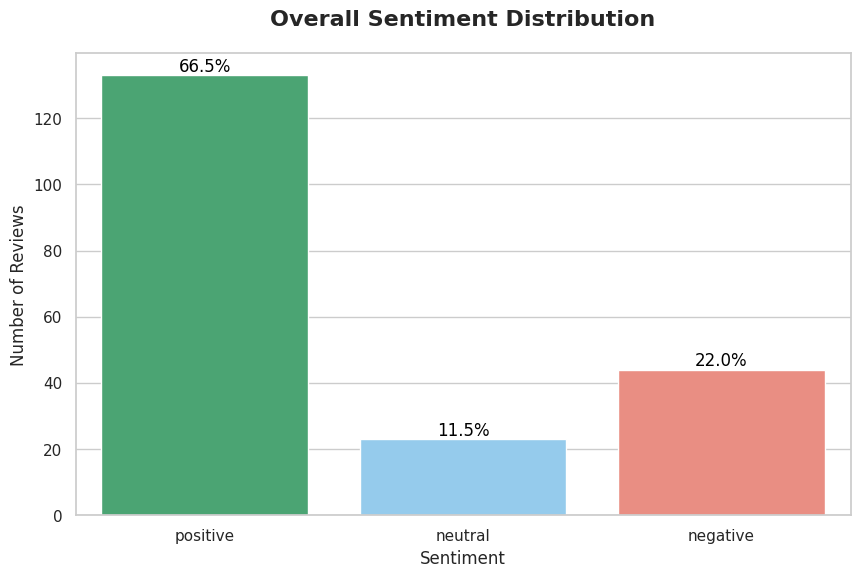

In [61]:
# Setting the visualization style
sns.set_theme(style="whitegrid", palette="pastel")

# prepare the figure
plt.figure(figsize=(10, 6))

# Creating a consistent color palette
palette_colors = {
    'positive': 'mediumseagreen',
    'negative': 'salmon',
    'neutral': 'lightskyblue'
}

# Creating a plot
ax = sns.countplot(
    x='sentiment',
    data=df_results,
    order=['positive', 'neutral', 'negative'],
    palette=palette_colors
)

# Adding titles and labels
ax.set_title('Overall Sentiment Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)

# Adds a percentage above each bar
total = len(df_results)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='black')

plt.show()

* Dominantly Positive: The sentiment analysis confirms the trend seen in the original ratings. A significant majority of reviews (66.5%) are classified as positive, establishing a strong baseline of guest satisfaction.

* Actionable Negative Segment: Despite the overall positivity, a substantial segment of reviews (22.0%) are distinctly negative. This represents the most critical area for management to focus on, as it contains specific, actionable feedback for improvement.

* Valuable Neutral Feedback: The neutral reviews (11.5%), though the smallest group, are a key source of balanced and constructive criticism. These often highlight areas where a positive aspect of service was offset by a negative one, providing valuable, nuanced insights.


##2) Topic Frequency Analysis

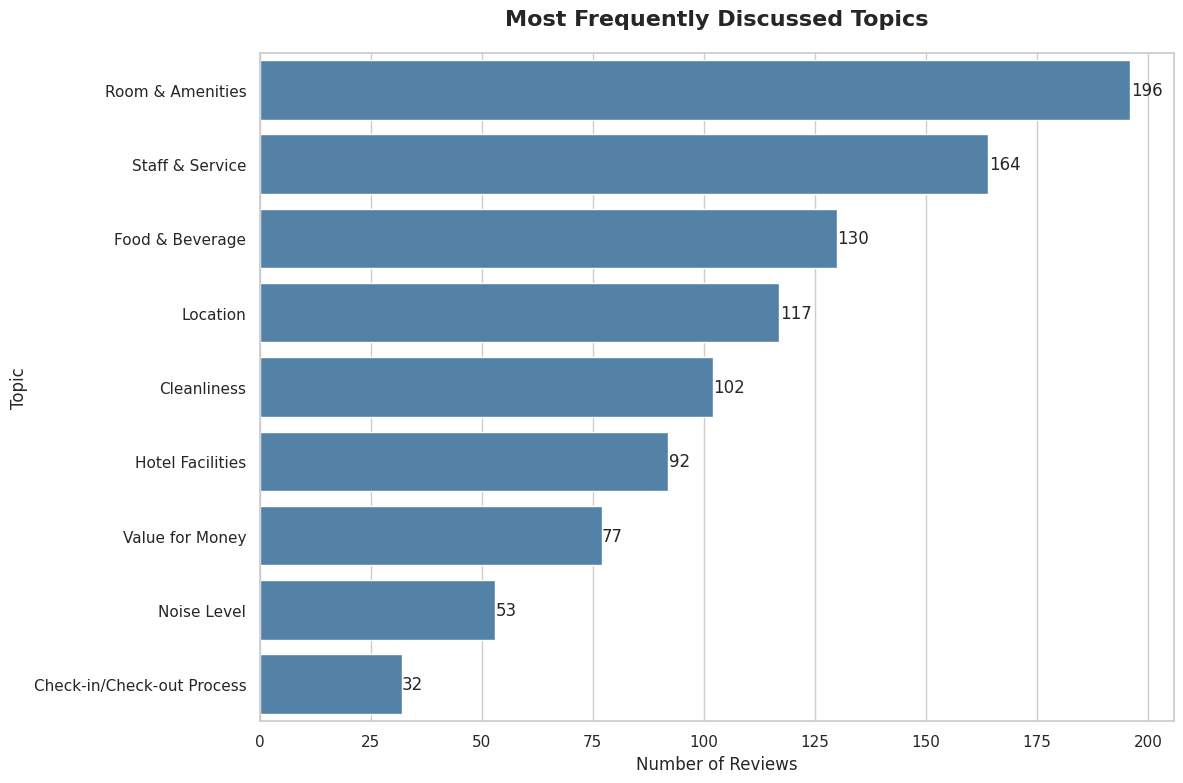

In [62]:
df_topics = df_results.explode('topics')

# prepare the figure
plt.figure(figsize=(12, 8))

# Creating a plot
ax = sns.countplot(
    y='topics',
    data=df_topics,
    order=df_topics['topics'].value_counts().index,
    color='steelblue'
)

# Adding titles and labels
ax.set_title('Most Frequently Discussed Topics', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Number of Reviews', fontsize=12)
ax.set_ylabel('Topic', fontsize=12)

# Adds the amount at the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1, p.get_y() + p.get_height() / 2,
             f'{int(width)}',
             va='center')

plt.tight_layout()
plt.show()


* Core Experience Drivers: The analysis reveals that the guest experience is primarily defined by two key areas: "Room & Amenities" and "Staff & Service". These are the most frequently discussed topics, indicating they have the highest impact on a guest's overall impression.

* Secondary Impact Factors: Topics like "Food & Beverage," "Location," and "Cleanliness" form a secondary tier of importance. While not discussed as often as rooms or staff, they still represent significant components of the hotel stay that frequently attract guest feedback.

* Lower Frequency, Niche Topics: Procedural aspects like "Check-in/Check-out Process" and ambient conditions like "Noise Level" are mentioned least frequently. While less common, feedback on these topics can often point to specific, easily rectifiable operational issues.

##3) Sentiment Breakdown for each Topic

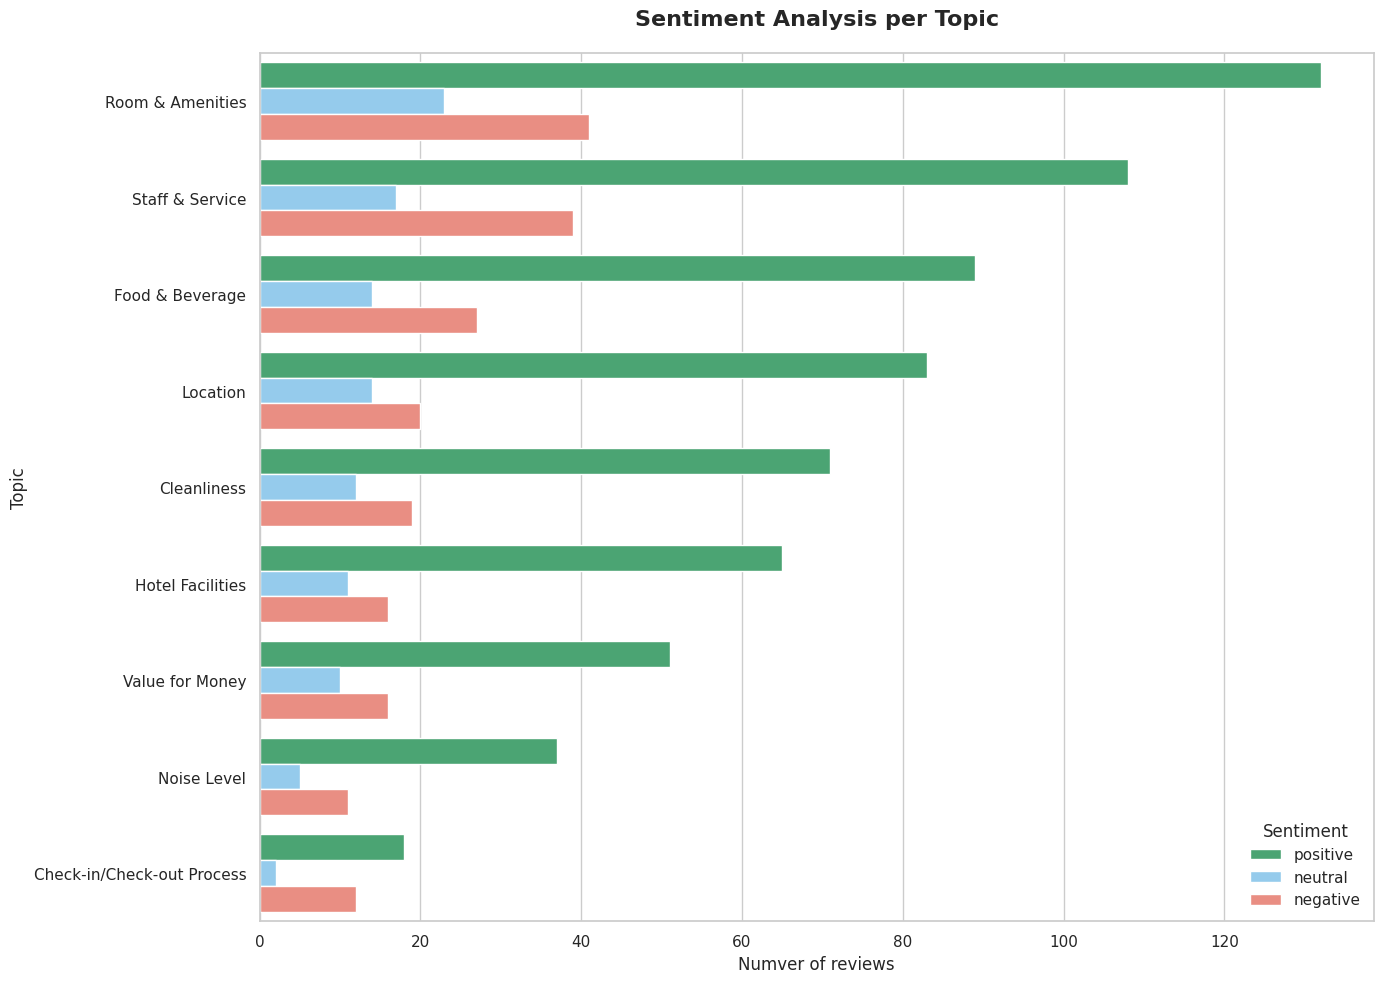

In [63]:
# prepare the figure
plt.figure(figsize=(14, 10))

# Taking the order of topics from the highest frequency
topic_order = df_topics['topics'].value_counts().index

# Creating a plot
ax = sns.countplot(
    y='topics',
    hue='sentiment',
    data=df_topics,
    order=topic_order,
    hue_order=['positive', 'neutral', 'negative'],
    palette=palette_colors
)

# Adding titles and labels
ax.set_title('Sentiment Analysis per Topic', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Numver of reviews', fontsize=12)
ax.set_ylabel('Topic', fontsize=12)
ax.legend(title='Sentiment')

plt.tight_layout()
plt.show()

* "Room & Amenities" is a Double-Edged Sword: While this is the most talked-about topic, it is also the primary source of negative feedback. The significant red bar indicates that issues with rooms are the main driver of guest dissatisfaction, making it a critical area for immediate improvement.

* Clear Strengths Identified: Topics like "Staff & Service," "Location," and "Food & Beverage" show a dominant proportion of positive sentiment. These are clearly the hotel's core strengths and key drivers of positive reviews.

* "Cleanliness" as a Red Flag: Despite not being the most frequently mentioned topic, "Cleanliness" has a relatively high ratio of negative to positive comments. This suggests that when cleanliness issues do occur, they leave a strong negative impression on guests, highlighting it as a high-impact area requiring consistent operational focus.

##4) The Priority Matrix

In [64]:
if 'df_results' in locals():
    # 1. Explode topics list
    df_exploded = df_results.explode('topics')

    # 2. Map sentiment to score
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    df_exploded['sentiment_score'] = df_exploded['sentiment'].map(sentiment_map)

    # 3. Aggregate data
    matrix_data = df_exploded.groupby('topics').agg(
        frequency=('topics', 'size'),
        avg_sentiment=('sentiment_score', 'mean')
    ).reset_index()
    print("\nAggregate Data for Priority Matrix:")
    display(matrix_data)

else:
  print("\nThere is not enough data to create a priority matrix.")


Aggregate Data for Priority Matrix:


,topics,frequency,avg_sentiment
0,Check-in/Check-out Process,32,0.187500
1,Cleanliness,102,0.509804
2,Food & Beverage,130,0.476923
3,Hotel Facilities,92,0.532609
4,Location,117,0.538462
5,Noise Level,53,0.490566
6,Room & Amenities,196,0.464286
7,Staff & Service,164,0.420732
8,Value for Money,77,0.454545


##5) Dashboard Priority Matrix

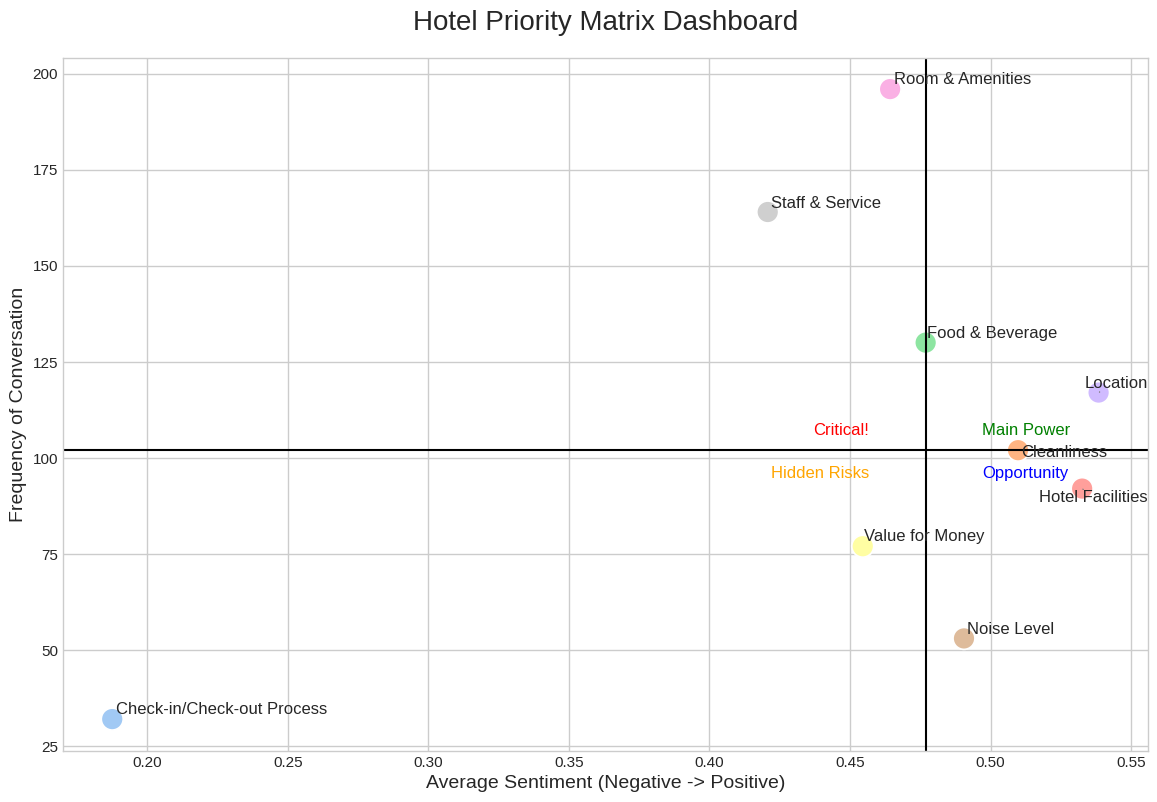

In [65]:
if 'matrix_data' in locals() and not matrix_data.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 9))
    sns.scatterplot(data=matrix_data, x='avg_sentiment', y='frequency', hue='topics', s=250, ax=ax, legend=False)

    texts = [ax.text(row['avg_sentiment'], row['frequency'], row['topics'], fontsize=12) for i, row in matrix_data.iterrows()]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=0.5))


    avg_sent_median = matrix_data['avg_sentiment'].median()
    freq_median = matrix_data['frequency'].median()
    ax.axhline(freq_median, color='black', linestyle='-'); ax.axvline(avg_sent_median, color='black', linestyle='-')
    plt.text(avg_sent_median + 0.02, freq_median * 1.04, 'Main Power', color='green', fontsize=12, ha='left')
    plt.text(avg_sent_median - 0.02, freq_median * 1.04, 'Critical!', color='red', fontsize=12, ha='right')
    plt.text(avg_sent_median - 0.02, freq_median * 0.96, 'Hidden Risks', color='orange', fontsize=12, ha='right', va='top')
    plt.text(avg_sent_median + 0.02, freq_median * 0.96, 'Opportunity', color='blue', fontsize=12, ha='left', va='top')

    ax.set_title('Hotel Priority Matrix Dashboard', fontsize=20, pad=20)
    ax.set_xlabel('Average Sentiment (Negative -> Positive)', fontsize=14)
    ax.set_ylabel('Frequency of Conversation', fontsize=14)
    plt.show()

##Insight from the Priority Matrix<br>
Based on the corrected data, the Priority Matrix provides a much more accurate and distinct strategic guide. By mapping topic frequency against average sentiment, we can identify four strategic quadrants:

1. Core Strengths (High Frequency, High Sentiment):
    * Topics: Location, Hotel Facilities, Cleanliness.

    * Insight: These topics are the pillars of the hotel's positive reputation. Location and Cleanliness are frequently praised, indicating high and consistent standards. These are key strengths that must be maintained and highlighted in marketing efforts.

2. Critical Issues (High Frequency, Low Relative Sentiment):

    * Topics: Room & Amenities, Staff & Service.

    * Insight: These are the two most high-impact areas detracting from the guest experience. Despite being frequently discussed, their sentiment scores are relatively low compared to the core strengths. Improvements in rooms and staff service must be the top operational priority to address.

3. Hidden Risks (Low Frequency, Very Low Sentiment):

    * Topic: Check-in/Check-out Process.

    * Insight: This is the clearest "red flag." Although infrequently mentioned, this topic has the lowest sentiment score of all (0.18). This indicates a fundamental issue within the check-in/out process that is highly frustrating for guests. If unaddressed, this small issue could undermine the entire guest experience.

4. Opportunities (Low Frequency, Favorable Sentiment):

    * Topics: Value for Money, Noise Level.

    * Insight: Guests who discuss these topics tend to have a favorable sentiment. There is an opportunity to improve perception in these areas. For instance, with minor improvements in soundproofing (Noise Level) or by offering more attractive packages (Value for Money), the hotel could elevate these topics into new strengths.

#5. Conclusion and Recommendations

A comprehensive analysis of guest reviews has identified key strategic areas requiring immediate action. The following are the main conclusions combined with their actionable recommendations:

1. Address Critical Issues to Prevent Recurring Negative Experiences

    * Conclusion: The data clearly indicates that Room & Amenities and Staff & Service are the most frequent and impactful sources of complaints. Issues in these two areas are the primary drivers of a negative guest experience.

    * Recommendation: Take immediate corrective action in both areas. Form a team to conduct regular audits of room conditions and implement retraining programs for staff, focusing on problem resolution. The goal is to ensure that future guests do not encounter the same recurring issues.

2. Transform Hidden Risks into Innovative Advantages

    * Conclusion: The Check-in/Check-out Process was identified as a "hidden risk" with the lowest sentiment score. Although infrequently mentioned, this process creates a high degree of frustration for guests who experience issues with it.

    * Recommendation: Don't just fix it—innovate. Turn this process into a point of excellence. Review the workflow to make it faster and more efficient, for example, by adopting self-check-in technology or providing a more comfortable waiting area. This has the potential to transform a point of friction into a memorable first and last impression.

3. Amplify Proven Strengths in Marketing

    * Conclusion: The hotel has a very strong foundation in its Location, Cleanliness, and Hotel Facilities. These three aspects are consistent sources of praise and guest satisfaction.

    * Recommendation: Amplify these strengths in all marketing materials. Use specific positive testimonials highlighting the strategic location and guaranteed cleanliness as social proof to attract customers and build a solid reputation.